# Introduction

This Python script assumes PCI does not have a working report management system in place. This automates the extraction of key operational data from email files, such as Site Name, Nature of Work, and ISO Cause Code, commonly found in PCI emails related to power generation events (e.g., maintenance, upgrades). The script decodes email content, extracts relevant data using regular expressions, and exports it to a CSV file for integration with Power BI and Tableau. It also visualizes the number of events per site, broken down by event type, through a stacked bar chart. Emails are sampled from September 1 - September 17, 2024.

# Importing Libraries

In [5]:
import os
import zipfile
from email import policy
from email.parser import BytesParser
import collections
import re
import csv
import matplotlib.pyplot as plt

# Extract Email Content 

In [7]:
# import dataset 
zip_file_path="/Users/bandito/Documents/FA24/edf/oms-emails.zip"
file_path = '/Users/bandito/Documents/FA24/edf/oms-emails'
# create folder to extract if doesn't exist
os.makedirs(file_path, exist_ok=True)

# unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)

# function to extract email content from an .eml file
def extract_email_content(file_path):
    with open(file_path, 'rb') as file:
        msg = BytesParser(policy=policy.default).parse(file)
    
    # detect charset from the header
    charset = msg.get_content_charset() if msg.get_content_charset() else 'utf-8'
    
    # get email data (body)
    if msg.is_multipart():
        for part in msg.iter_parts():
            if part.get_content_type() == "text/plain":
                try:
                    return part.get_payload(decode=True).decode(charset)
                except UnicodeDecodeError:
                    return part.get_payload(decode=True).decode('ISO-8859-1', errors='replace')  # Fallback to another encoding
    else:
        try:
            return msg.get_payload(decode=True).decode(charset)
        except UnicodeDecodeError:
            return msg.get_payload(decode=True).decode('ISO-8859-1', errors='replace')

# Extract Key Data Using Regex

In [9]:
# function to extract field with regular expressions
def extract_info_from_email(content):
    # regex patterns to find site name, nature of work, and ISO cause code
    site_name_pattern = r"Please see outage request for\s(.+)"
    nature_of_work_pattern = r"Nature of Work:\s(.+)"
    iso_code_pattern = r"ISO Cause Code:\s(.+?)\n"
    
    site_name_match = re.search(site_name_pattern, content)
    nature_of_work_match = re.search(nature_of_work_pattern, content)
    iso_code_match = re.search(iso_code_pattern, content)
    
    site_name = site_name_match.group(1).strip() if site_name_match else "N/A"
    nature_of_work = nature_of_work_match.group(1).strip() if nature_of_work_match else "N/A"
    iso_code = iso_code_match.group(1).strip() if iso_code_match else "N/A"
    
    return site_name, nature_of_work, iso_code

# Multiple Email Process Handling

In [11]:
# function to process all .eml files into a single directory
def process_eml_files(directory):
    extracted_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".eml"):
            file_path = os.path.join(directory, filename)
            content = extract_email_content(file_path)
            site_name, nature_of_work, iso_code = extract_info_from_email(content)
            extracted_data.append((site_name, nature_of_work, iso_code))
    
    return extracted_data

# Export CSV

In [13]:
# function to export extracted data to a CSV file
def export_to_csv(email_data, output_file):
    # Define the headers for the CSV
    headers = ['Site Name', 'Nature of Work', 'ISO Cause Code']
    
    # write data to a CSV file
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(email_data)
    
    print(f"Data exported to {output_file}") # sanity check

# Create Stacked Chart

In [15]:
# visualization to stacked charts
def create_event_chart(email_data):
    # organize by site and event type 
    site_event_counter = collections.defaultdict(lambda: collections.Counter())

    for site, event, iso_code in email_data:
        site_event_counter[site][event] += 1

    # date to plot 
    sites = list(site_event_counter.keys())
    event_types = list({event for events in site_event_counter.values() for event in events})

    # initialize a dictionary to hold count
    event_data_per_site = {site: [site_event_counter[site].get(event, 0) for event in event_types] for site in sites}

    # create a stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    bottom = [0] * len(sites)
    for i, event_type in enumerate(event_types):
        event_counts = [event_data_per_site[site][i] for site in sites]
        ax.bar(sites, event_counts, label=event_type, bottom=bottom)
        bottom = [x + y for x, y in zip(bottom, event_counts)]

    # labels
    plt.xlabel('Site Name')
    plt.ylabel('Number of Events')
    plt.title('Number of Events per Site by Event Type')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Event Type')

    # display plot
    plt.tight_layout()
    plt.show()

Data exported to extracted_event_data.csv


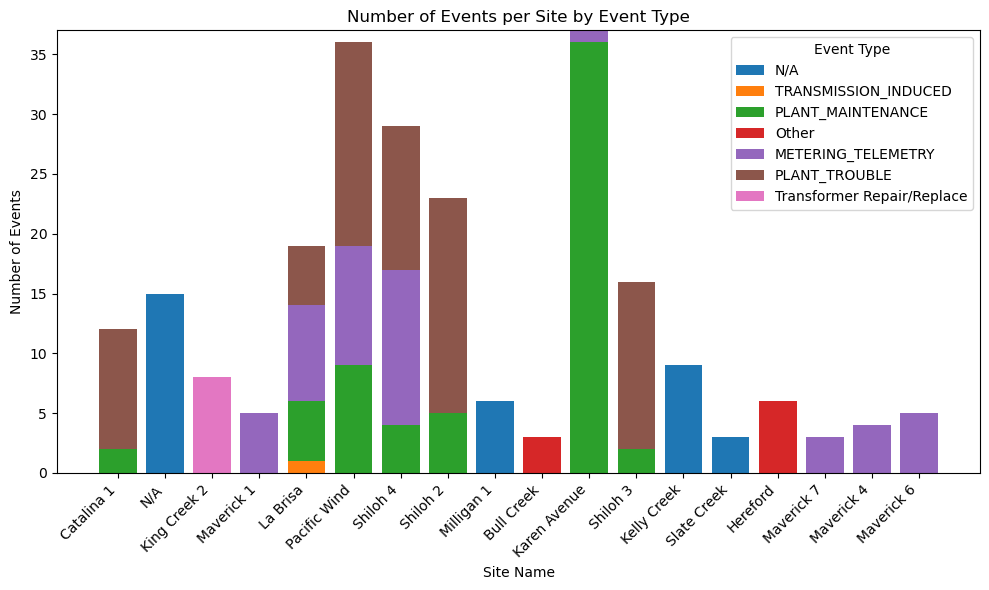

In [16]:
# driver 
directory_path = file_path  # Replace with your .eml files directory
email_data = process_eml_files(directory_path)

# export the data to CSV 
output_file = 'extracted_event_data.csv'
export_to_csv(email_data, output_file)

# create a chart 
create_event_chart(email_data)